# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

### Init

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
# create gdrive shortcut using url "https://drive.google.com/open?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL"  -- note the open which is required to allow to create shortcut
#!unzip -d '/content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment' 'Project_data.zip'

Mounted at /content/gdrive


In [3]:
#cd /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment

In [4]:
#!wget "https://drive.google.com/open?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL"
#!wget -O Project_data.zip "$file_share_link"
#!ls -lrt
#!df -h "/content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data"

In [5]:
import pandas as pd
import numpy as np
import os
import datetime
import os
import matplotlib.pyplot as plt
from skimage import io
import glob
import cv2

from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

We set the random seed so that the results don't vary drastically.

In [6]:
#from google.colab.patches import cv_imread

In [7]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

### Inspect Data & View Images

In [8]:
# Setup the paths
DATA_DIR='/content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/'
DATA_DIR_TRAIN = DATA_DIR + 'train/'
DATA_DIR_VAL = DATA_DIR + 'val/'

In [9]:
# Lets inspect the train data and see how many videos are available per label
train_df = pd.read_csv(DATA_DIR + 'train.csv', delimiter=';', header=None)
train_df.columns = ['name', 'type', 'label']
train_df.head()
train_df.groupby(by=['type', 'label'])['name'].count()

type                           label
Left Swipe_new_Left Swipe_new  0         40
Left_Swipe_new                 0         96
Right Swipe_new                1         34
Right_Swipe_new                1        103
Stop Gesture_new               2         37
Stop_new                       2         93
Thumbs Down_new                3         37
Thumbs Up_new                  4         36
Thumbs_Down_new                3        100
Thumbs_Up_new                  4         87
Name: name, dtype: int64

In [10]:
val_df = pd.read_csv(DATA_DIR + 'val.csv', delimiter=';', header=None)
val_df.columns = ['name', 'type', 'label']
val_df.head()
val_df.groupby(by=['type', 'label'])['name'].count()

type                           label
Left Swipe_new_Left Swipe_new  0         5
Left_Swipe_new                 0        13
Right Swipe_new                1        10
Right_Swipe_new                1        13
Stop Gesture_new               2         8
Stop_new                       2        14
Thumbs Down_new                3         9
Thumbs Up_new                  4         6
Thumbs_Down_new                3        12
Thumbs_Up_new                  4        10
Name: name, dtype: int64

In [11]:
train_df.head()

,name,type,label
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left_Swipe_new,0


In [12]:
train_doc = np.random.permutation(open(DATA_DIR + 'train.csv').readlines())
val_doc = np.random.permutation(open(DATA_DIR + 'val.csv').readlines())
#batch_size = 3 #experiment with the batch size  -- Moved below to Model Creation section

/content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/WIN_20180925_17_08_43_Pro_Left_Swipe_new/*


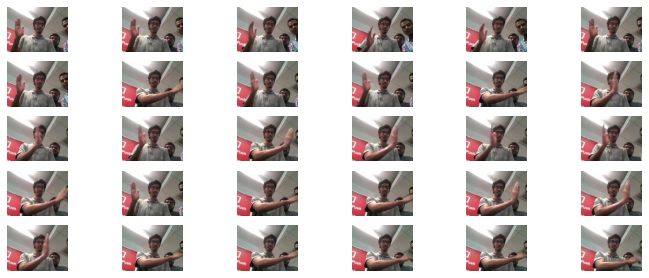

In [13]:
# Lets check the frames for a video

sample_img_path = os.path.join(DATA_DIR_TRAIN, train_df.iloc[0][0], '*')
print(sample_img_path)
sample_img_list = glob.glob(sample_img_path)
sample_img_list

plt.figure(figsize=(12, 30))
for k, file_name in enumerate(sample_img_list):
  ax = plt.subplot(len(sample_img_list), 6, k+1)
  plt.imshow(io.imread(file_name))
  plt.axis("off")

/content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/WIN_20180925_17_18_28_Pro_Left_Swipe_new/*


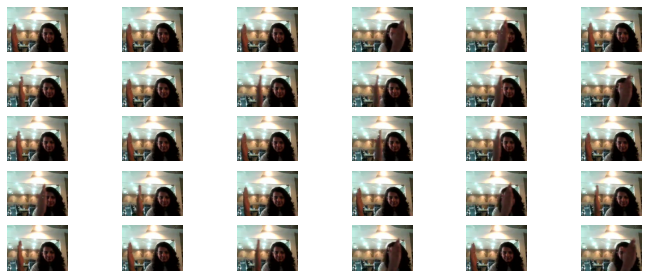

In [14]:
# And another video
sample_img_path = os.path.join(DATA_DIR_TRAIN, train_df.iloc[1][0], '*')
print(sample_img_path)
sample_img_list = glob.glob(sample_img_path)
sample_img_list

plt.figure(figsize=(12, 30))
for k, file_name in enumerate(sample_img_list):
  ax = plt.subplot(len(sample_img_list), 6, k+1)
  plt.imshow(io.imread(file_name))
  plt.axis("off")

/content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/WIN_20180925_17_18_56_Pro_Left_Swipe_new/*


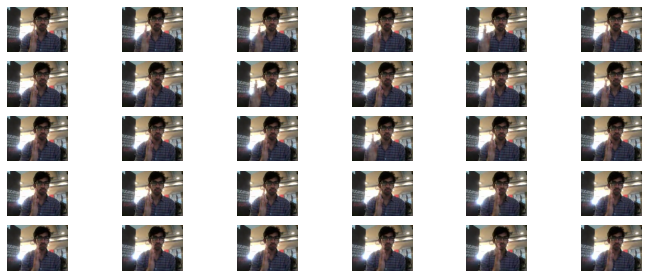

In [15]:
# And another video
sample_img_path = os.path.join(DATA_DIR_TRAIN, train_df.iloc[2][0], '*')
print(sample_img_path)
sample_img_list = glob.glob(sample_img_path)
sample_img_list

plt.figure(figsize=(12, 30))
for k, file_name in enumerate(sample_img_list):
  ax = plt.subplot(len(sample_img_list), 6, k+1)
  plt.imshow(io.imread(file_name))
  plt.axis("off")

(120, 160, 3) (120, 120, 3)


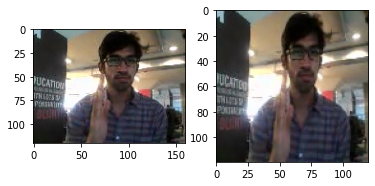

In [16]:
# lets try resize function from opencv and check for an image
i_img = io.imread(sample_img_list[0])
o_img = cv2.resize(i_img, (120, 120), interpolation = cv2.INTER_AREA)
print(i_img.shape, o_img.shape)

plt.subplot(1, 2, 1)
plt.imshow(i_img)

plt.subplot(1, 2, 2)
plt.imshow(o_img)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [17]:
def generator(source_path, folder_list, o_batch_size, img_idx = [0, 4, 8, 12, 16, 20, 24, 28], p_preprocess_input=False):
    print( '\nSource path = ', source_path, '; batch size =', o_batch_size)

     # img_idx create a list of image numbers you want to use for a particular video. Keep it as a parameter so that 
     # can experiment with different number of frames per video
    
    img_cnt = len(img_idx) # This is the number of frames per video we will use

    # Image size is fixed at 120x120 since the images are of 2 sizes different sizes - 360x360 or 120x160. 
    # Choose the lower res since if we try to extrapolate, the noise added will be higher. 
    # Plus a smaller image res means that our model will train faster
    width = 120 # Width of the image. 
    height = 120 # Height of the image

    while True:
        batch_size = o_batch_size # set the batch size depending on what has been passed

        t = np.random.permutation(folder_list)
        #print('folder count = ', len(t))
        
        num_batches = int(len(t)/batch_size)# calculate the number of batches
        #print('num_batches = ', num_batches)

        folders_remanining = (len(t) - num_batches*batch_size) # folders that will be left after creating batches
        print('\ntotalFolders=', len(t), 'num_batches = ', num_batches, 'folders_remanining=', folders_remanining)

        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size, img_cnt, width, height, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                #print('### folder=', folder, ' folder_index=', (folder + (batch*batch_size)), '########')
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # Cropping is not done since it may cause important feature to be lost. 
                    image = cv2.resize(image, (width, height), interpolation = cv2.INTER_AREA)

                    if p_preprocess_input: #if resnet50 is being used then it needs to be pre-processed to convert image from RGB to BGR
                      image = preprocess_input(image)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        #write the code for the remaining data points which are left after full batches
        if folders_remanining > 0: 
          batch = 1 # we will have only one batch remaning

          start_from = num_batches * batch_size # calculate the index where the batching process ended

          end_at = len(t) # calculate the index of the last folder

          batch_size = folders_remanining # set the batch_size
          
          print('\nPending - folders_remanining', folders_remanining, 'start_from=',start_from, 'end_at=', end_at, 'batch_size=', batch_size)

          batch_data = np.zeros((batch_size, img_cnt, width, height, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
          batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
          #for batch*batch_size+1 in range(len(t)): # iterate over the batch_size

          folder_idx = 0 # since now the folder starts at the index where the previous batch creation ended, we need a new variable to index the batch_data and batch_labels
          for folder in range(start_from, end_at): # iterate using start and end

              imgs = os.listdir(source_path+'/'+ t[folder].split(';')[0]) # read all the images in the folder now identified by folder index
              
              for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                  #print('### folder=', folder, '########')

                  image = io.imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                  
                  #crop the images and resize them. Note that the images are of 2 different shape 
                  #and the conv3D will throw error if the inputs in a batch have different shapes

                  image = cv2.resize(image, (width, height), interpolation = cv2.INTER_AREA)
                  
                  batch_data[folder_idx,idx,:,:,0] = image[:,:,0]/255#normalise and feed in the image
                  batch_data[folder_idx,idx,:,:,1] = image[:,:,1]/255#normalise and feed in the image
                  batch_data[folder_idx,idx,:,:,2] = image[:,:,2]/255#normalise and feed in the image
                  
              batch_labels[folder_idx, int(t[folder].strip().split(';')[2])] = 1
              folder_idx = folder_idx + 1
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [18]:
# Test the generator for different batch_sizes, uncomment the prints in generator program before runnung the following to see that 
# all folders are considered 

train_doc_sample = train_doc[0:11]
batch_size = 3
img_idx = [0]
gen = generator(DATA_DIR_TRAIN, train_doc_sample, batch_size, img_idx, p_preprocess_input=False)
#train_doc_sample

In [19]:
next(gen)
next(gen)
next(gen)
next(gen)


Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 3

totalFolders= 11 num_batches =  3 folders_remanining= 2

Pending - folders_remanining 2 start_from= 9 end_at= 11 batch_size= 2


(array([[[[[0.5411765 , 0.50980395, 0.48627451],
           [0.5411765 , 0.51176471, 0.49215686],
           [0.53529412, 0.51078433, 0.49509802],
           ...,
           [0.43823528, 0.43431371, 0.40392157],
           [0.43725491, 0.43333334, 0.41176471],
           [0.43921569, 0.43529412, 0.41960785]],
 
          [[0.53333336, 0.50196081, 0.47450981],
           [0.52941179, 0.50196081, 0.47843137],
           [0.52254903, 0.49901959, 0.47941175],
           ...,
           [0.43921569, 0.43529412, 0.40588236],
           [0.43921569, 0.43529412, 0.41568628],
           [0.43921569, 0.43529412, 0.41960785]],
 
          [[0.50196081, 0.48235294, 0.44313726],
           [0.50196081, 0.48627451, 0.4509804 ],
           [0.50196081, 0.49019608, 0.45882353],
           ...,
           [0.43921569, 0.43529412, 0.41176471],
           [0.43725491, 0.43333334, 0.40784314],
           [0.43823528, 0.43431371, 0.40980393]],
 
          ...,
 
          [[0.11176471, 0.11078431, 0.069607

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [20]:
curr_dt_time = datetime.datetime.now()
train_path = DATA_DIR_TRAIN
val_path = DATA_DIR_VAL
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


### Check data created by the generator

In [21]:
# Check that the left over are also served 
train_generator = generator(train_path, train_doc[0:3], 2, p_preprocess_input=True)

for i in range(7):
  batch_data, batch_labels = next(train_generator)
  print(batch_data.shape)


Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 2

totalFolders= 3 num_batches =  1 folders_remanining= 1
(2, 8, 120, 120, 3)

Pending - folders_remanining 1 start_from= 2 end_at= 3 batch_size= 1
(1, 8, 120, 120, 3)

totalFolders= 3 num_batches =  1 folders_remanining= 1
(2, 8, 120, 120, 3)

Pending - folders_remanining 1 start_from= 2 end_at= 3 batch_size= 1
(1, 8, 120, 120, 3)

totalFolders= 3 num_batches =  1 folders_remanining= 1
(2, 8, 120, 120, 3)

Pending - folders_remanining 1 start_from= 2 end_at= 3 batch_size= 1
(1, 8, 120, 120, 3)

totalFolders= 3 num_batches =  1 folders_remanining= 1
(2, 8, 120, 120, 3)


In [22]:
## check if normalization worked 
batch_data[0][0]

array([[[-0.23211373, -0.22462353, -0.12717648],
        [-0.23701569, -0.23050588, -0.11835294],
        [-0.23015295, -0.22756471, -0.09776471],
        ...,
        [-0.28113335, -0.32364315, -0.39776471],
        [-0.29191765, -0.33246666, -0.40266666],
        [-0.32034904, -0.35893726, -0.4222745 ]],

       [[-0.22819217, -0.23540784, -0.12521569],
        [-0.22721177, -0.23246667, -0.11835294],
        [-0.21740785, -0.22364314, -0.09384314],
        ...,
        [-0.13995688, -0.18540785, -0.25658825],
        [-0.20564315, -0.24619216, -0.31443137],
        [-0.25662354, -0.29227057, -0.35756862]],

       [[-0.22623138, -0.24521177, -0.12717648],
        [-0.21936864, -0.23638824, -0.11443137],
        [-0.20956472, -0.22462353, -0.09580392],
        ...,
        [ 0.01200391, -0.04129019, -0.11247059],
        [-0.05074119, -0.09913333, -0.17129412],
        [-0.10466275, -0.14227058, -0.21541177]],

       ...,

       [[-0.23015295, -0.30011374, -0.24482353],
        [-0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


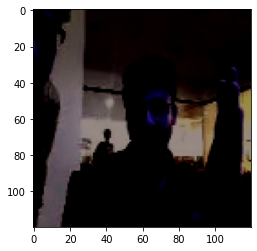

In [23]:
## check if the image is still the same after transformations
plt.imshow(batch_data[0][0])

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [24]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras import utils


## Model Functions

In [25]:
import pandas as pd
def print_best_epoc(history):  
  df = pd.DataFrame(history.history)
  print(df.iloc[df['val_categorical_accuracy'].idxmax()])

In [26]:
def train_model(curr_dt_time, batch_size, train_doc_sample, val_doc_sample, 
                num_epochs, p_preprocess_input, model, min_lr=0.00001, img_idx = [0, 4, 8, 12, 16, 20, 24, 28], 
                save_model=False, model_name='model'):

  num_train_sequences = len(train_doc_sample)
  print('# training sequences =', num_train_sequences)
  
  num_val_sequences = len(val_doc_sample)
  print('# validation sequences =', num_val_sequences)

  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1

  train_generator = generator(DATA_DIR_TRAIN, train_doc_sample, batch_size, img_idx, p_preprocess_input=p_preprocess_input)
  val_generator = generator(DATA_DIR_VAL, val_doc_sample, batch_size, img_idx, p_preprocess_input=p_preprocess_input)


  # setup params
  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=min_lr)# write the REducelronplateau code here

  if save_model:
    model_name = DATA_DIR + 'model_output/' + model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_')
      
    if not os.path.exists(model_name):
        os.mkdir(model_name)
            
    filepath = model_name + '/' + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, 
                                save_weights_only=False, mode='auto')

    callbacks_list = [checkpoint, LR]
  else:
    callbacks_list = [LR]

  # calculate steps per epoch and val steps
  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1
  
  # model.fit
  history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
  
  return history

In [27]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Building Conv3D

In [ ]:
# batch_size = 3

# train_doc_sample = train_doc[0:10]
# val_doc_sample = val_doc[0:10]

# curr_dt_time = datetime.datetime.now()
# train_path = DATA_DIR_TRAIN
# val_path = DATA_DIR_VAL
# num_train_sequences = len(train_doc)
# print('# training sequences =', num_train_sequences)
# num_val_sequences = len(val_doc)
# print('# validation sequences =', num_val_sequences)
# num_epochs = 5# choose the number of epochs
# print ('# epochs =', num_epochs)

In [ ]:
# train_generator = generator(train_path, train_doc_sample, batch_size)
# val_generator = generator(val_path, val_doc_sample, batch_size)

### Experiment-1

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(8, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
model.add(Dropout(0.2))

# Second Convolutional layer with Batch Normalisation followed by Pooling layer
model.add(Conv3D(16, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.2))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer
model.add(Conv3D(24, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.2))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Second Fully Connected Layer with Batch Normalisation
#model.add(Dense(256, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_26 (Conv3D)          (None, 15, 120, 120, 8)   1544      
                                                                 
 batch_normalization_38 (Bat  (None, 15, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_26 (MaxPoolin  (None, 5, 40, 40, 8)     0         
 g3D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 5, 40, 40, 8)      0         
                                                                 
 conv3d_27 (Conv3D)          (None, 5, 40, 40, 16)     3472      
                                                                 
 batch_normalization_39 (Bat  (None, 5, 40, 40, 16)  

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.0001, batch_size=64, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=5, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 64

totalFolders= 663 num_batches =  10 folders_remanining= 23
Epoch 1/5
 9/11 [=======================>......] - ETA: 2:22 - loss: 2.0820 - categorical_accuracy: 0.3247
Pending - folders_remanining 23 start_from= 640 end_at= 663 batch_size= 23
10/11 [==========================>...] - ETA: 1:10 - loss: 2.0601 - categorical_accuracy: 0.3328
totalFolders= 663 num_batches =  10 folders_remanining= 23
11/11 [==============================] - ETA: 0s - loss: 2.0578 - categorical_accuracy: 0.3333  
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 64

totalFolders= 100 num_batches =  1 folders_remanining= 36

Pending - folders_remanining 36 start_from= 64 end_at= 100 batch_size= 36

totalFolders= 100 num_batches =  1 folders_remanining= 36
11/11 [==========

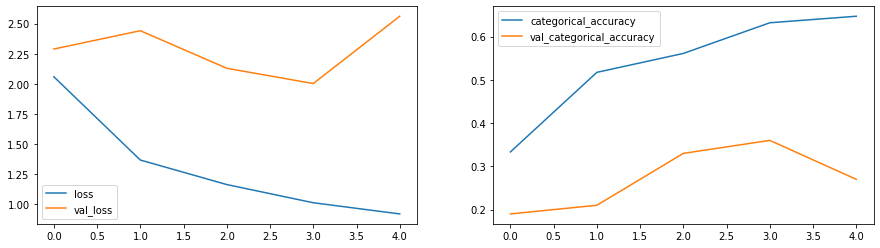

In [ ]:
plot(history)

### Experiment-2

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

# Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
model.add(Dropout(0.25))

# Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

# Thirdecond Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_29 (Conv3D)          (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization_42 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_29 (MaxPoolin  (None, 5, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 5, 40, 40, 16)     0         
                                                                 
 conv3d_30 (Conv3D)          (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_43 (Bat  (None, 5, 40, 40, 32)  

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.0001, batch_size=64, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=5, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 64

totalFolders= 663 num_batches =  10 folders_remanining= 23
Epoch 1/5
 9/11 [=======================>......] - ETA: 7s - loss: 2.0219 - categorical_accuracy: 0.3333 
Pending - folders_remanining 23 start_from= 640 end_at= 663 batch_size= 23
10/11 [==========================>...] - ETA: 3s - loss: 2.0045 - categorical_accuracy: 0.3438
totalFolders= 663 num_batches =  10 folders_remanining= 23
11/11 [==============================] - ETA: 0s - loss: 1.9969 - categorical_accuracy: 0.3454
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 64

totalFolders= 100 num_batches =  1 folders_remanining= 36

Pending - folders_remanining 36 start_from= 64 end_at= 100 batch_size= 36

totalFolders= 100 num_batches =  1 folders_remanining= 36
11/11 [===============

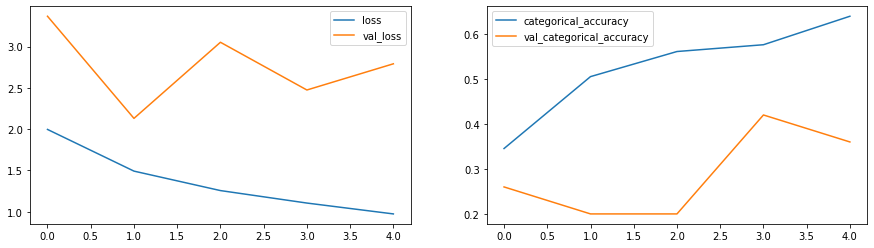

In [ ]:
plot(history)

### Experiment-3

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

# Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
model.add(Dropout(0.25))

# Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

# Thirdecond Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization_47 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 5, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 5, 40, 40, 16)     0         
                                                                 
 conv3d_33 (Conv3D)          (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_48 (Bat  (None, 5, 40, 40, 32)  

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.0001, batch_size=64, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=20, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 64

totalFolders= 663 num_batches =  10 folders_remanining= 23
Epoch 1/20
 9/11 [=======================>......] - ETA: 8s - loss: 2.0798 - categorical_accuracy: 0.3281 
Pending - folders_remanining 23 start_from= 640 end_at= 663 batch_size= 23
10/11 [==========================>...] - ETA: 4s - loss: 2.0803 - categorical_accuracy: 0.3219
totalFolders= 663 num_batches =  10 folders_remanining= 23
11/11 [==============================] - ETA: 0s - loss: 2.0561 - categorical_accuracy: 0.3303
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 64

totalFolders= 100 num_batches =  1 folders_remanining= 36

Pending - folders_remanining 36 start_from= 64 end_at= 100 batch_size= 36

totalFolders= 100 num_batches =  1 folders_remanining= 36
11/11 [==============

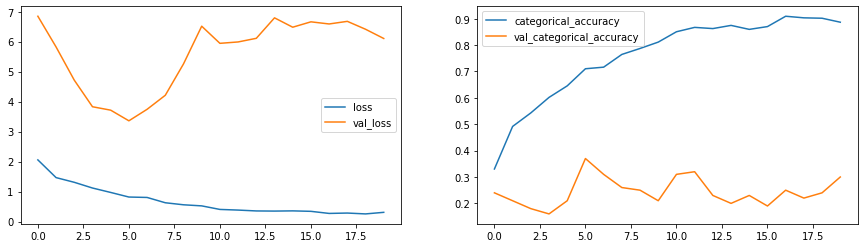

In [ ]:
plot(history)

### Experiment-4

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
model.add(Dropout(0.3))

#Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.3))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.3))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization (BatchN  (None, 15, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 40, 40, 16)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5, 40, 40, 16)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_1 (Batc  (None, 5, 40, 40, 32)    1

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.0001, batch_size=64, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=20, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 64

totalFolders= 663 num_batches =  10 folders_remanining= 23
Epoch 1/20
 9/11 [=======================>......] - ETA: 7s - loss: 1.7542 - categorical_accuracy: 0.3819 
Pending - folders_remanining 23 start_from= 640 end_at= 663 batch_size= 23
10/11 [==========================>...] - ETA: 3s - loss: 1.7264 - categorical_accuracy: 0.3844
totalFolders= 663 num_batches =  10 folders_remanining= 23
11/11 [==============================] - ETA: 0s - loss: 1.7227 - categorical_accuracy: 0.3801
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 64

totalFolders= 100 num_batches =  1 folders_remanining= 36

Pending - folders_remanining 36 start_from= 64 end_at= 100 batch_size= 36

totalFolders= 100 num_batches =  1 folders_remanining= 36
11/11 [==============

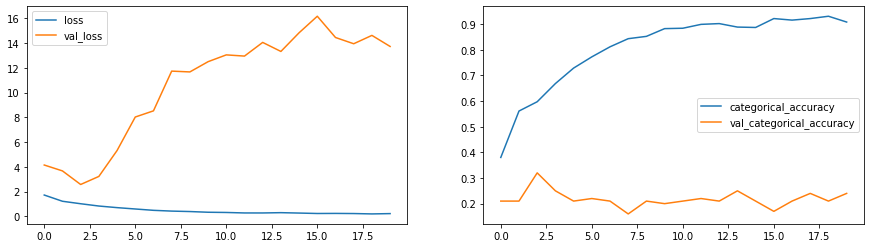

In [ ]:
plot(history)

### Experiment-5

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
model.add(Dropout(0.3))

#Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.3))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.3))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization_5 (Batc  (None, 15, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 5, 40, 40, 16)    0         
 3D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 5, 40, 40, 16)     0         
                                                                 
 conv3d_4 (Conv3D)           (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_6 (Batc  (None, 5, 40, 40, 32)   

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
train_model(curr_dt_time, min_lr=0.00000001, batch_size=40, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=23, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 40

totalFolders= 663 num_batches =  16 folders_remanining= 23
Epoch 1/23
15/17 [=========================>....] - ETA: 4s - loss: 1.8261 - categorical_accuracy: 0.3767
Pending - folders_remanining 23 start_from= 640 end_at= 663 batch_size= 23
16/17 [===========================>..] - ETA: 2s - loss: 1.7762 - categorical_accuracy: 0.3922
totalFolders= 663 num_batches =  16 folders_remanining= 23
17/17 [==============================] - ETA: 0s - loss: 1.7421 - categorical_accuracy: 0.4042
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 40

totalFolders= 100 num_batches =  2 folders_remanining= 20

Pending - folders_remanining 20 start_from= 80 end_at= 100 batch_size= 20

totalFolders= 100 num_batches =  2 folders_remanining= 20
17/17 [===============

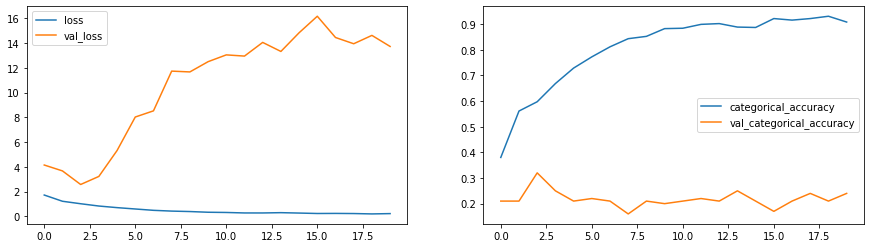

In [ ]:
plot(history)

### Experiment-6

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
model.add(Dropout(0.1))

#Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.35))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.35))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization_10 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 5, 40, 40, 16)    0         
 3D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 5, 40, 40, 16)     0         
                                                                 
 conv3d_7 (Conv3D)           (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_11 (Bat  (None, 5, 40, 40, 32)   

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.000000000001, batch_size=40, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=30, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 40

totalFolders= 663 num_batches =  16 folders_remanining= 23
Epoch 1/30
15/17 [=========================>....] - ETA: 5s - loss: 1.7984 - categorical_accuracy: 0.3700
Pending - folders_remanining 23 start_from= 640 end_at= 663 batch_size= 23
16/17 [===========================>..] - ETA: 2s - loss: 1.7880 - categorical_accuracy: 0.3750
totalFolders= 663 num_batches =  16 folders_remanining= 23
17/17 [==============================] - ETA: 0s - loss: 1.7815 - categorical_accuracy: 0.3741
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 40

totalFolders= 100 num_batches =  2 folders_remanining= 20

Pending - folders_remanining 20 start_from= 80 end_at= 100 batch_size= 20

totalFolders= 100 num_batches =  2 folders_remanining= 20
17/17 [===============

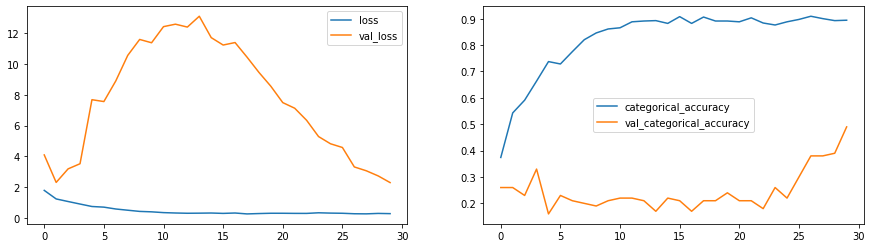

In [ ]:
plot(history)

### Experiment-7

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
model.add(Dropout(0.15))

#Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.35))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.40))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.45))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.45))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization_15 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 5, 40, 40, 16)    0         
 3D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 5, 40, 40, 16)     0         
                                                                 
 conv3d_10 (Conv3D)          (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_16 (Bat  (None, 5, 40, 40, 32)   

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.000000000000001, batch_size=35, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=35, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 35

totalFolders= 663 num_batches =  18 folders_remanining= 33
Epoch 1/35
17/19 [=========================>....] - ETA: 4s - loss: 2.1399 - categorical_accuracy: 0.3445
Pending - folders_remanining 33 start_from= 630 end_at= 663 batch_size= 33
18/19 [===========================>..] - ETA: 2s - loss: 2.1122 - categorical_accuracy: 0.3476
totalFolders= 663 num_batches =  18 folders_remanining= 33
19/19 [==============================] - ETA: 0s - loss: 2.0731 - categorical_accuracy: 0.3560
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 35

totalFolders= 100 num_batches =  2 folders_remanining= 30

Pending - folders_remanining 30 start_from= 70 end_at= 100 batch_size= 30

totalFolders= 100 num_batches =  2 folders_remanining= 30
19/19 [===============

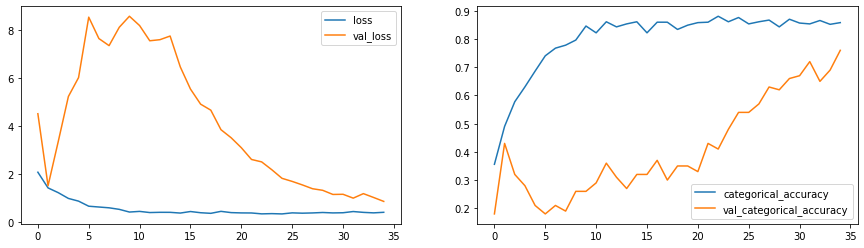

In [ ]:
plot(history)

### Experiment-8

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
model.add(Dropout(0.05))

#Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.40))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.45))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization_20 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 5, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 5, 40, 40, 16)     0         
                                                                 
 conv3d_13 (Conv3D)          (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_21 (Bat  (None, 5, 40, 40, 32)   

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.000000000000001, batch_size=35, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=45, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 35

totalFolders= 663 num_batches =  18 folders_remanining= 33
Epoch 1/45
17/19 [=========================>....] - ETA: 4s - loss: 2.5766 - categorical_accuracy: 0.2504
Pending - folders_remanining 33 start_from= 630 end_at= 663 batch_size= 33
18/19 [===========================>..] - ETA: 2s - loss: 2.5446 - categorical_accuracy: 0.2556
totalFolders= 663 num_batches =  18 folders_remanining= 33
19/19 [==============================] - ETA: 0s - loss: 2.5061 - categorical_accuracy: 0.2640
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 35

totalFolders= 100 num_batches =  2 folders_remanining= 30

Pending - folders_remanining 30 start_from= 70 end_at= 100 batch_size= 30

totalFolders= 100 num_batches =  2 folders_remanining= 30
19/19 [===============

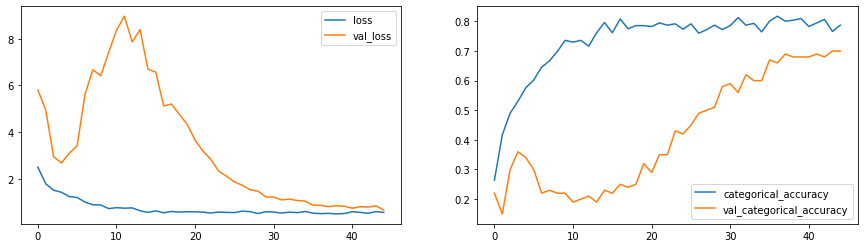

In [ ]:
plot(history)

### Experiment-9

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
#model.add(Dropout(0.05))

#Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.35))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.40))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization_25 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 5, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_16 (Conv3D)          (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_26 (Bat  (None, 5, 40, 40, 32)    128       
 chNormalization)                                                
                                                      

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.000000000000001, batch_size=25, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=45, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 25

totalFolders= 663 num_batches =  26 folders_remanining= 13
Epoch 1/45
25/27 [==========================>...] - ETA: 3s - loss: 2.1698 - categorical_accuracy: 0.3600
Pending - folders_remanining 13 start_from= 650 end_at= 663 batch_size= 13
26/27 [===========================>..] - ETA: 1s - loss: 2.1539 - categorical_accuracy: 0.3554
totalFolders= 663 num_batches =  26 folders_remanining= 13
27/27 [==============================] - ETA: 0s - loss: 2.1535 - categorical_accuracy: 0.3544
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 25

totalFolders= 100 num_batches =  4 folders_remanining= 0

totalFolders= 100 num_batches =  4 folders_remanining= 0
27/27 [==============================] - 50s 2s/step - loss: 2.1535 - categorical_accuracy: 0.3544 

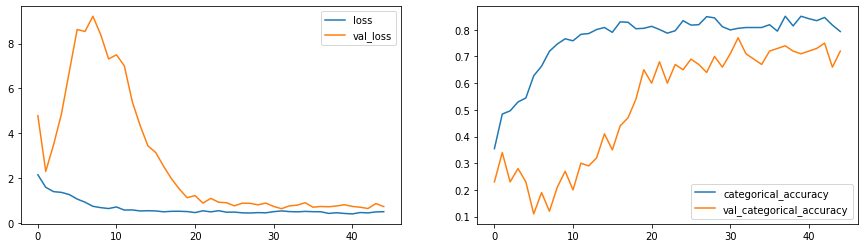

In [ ]:
plot(history)

### Experiment-10

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
#model.add(Dropout(0.05))

#Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.35))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.40))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization_30 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 5, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_31 (Bat  (None, 5, 40, 40, 32)    128       
 chNormalization)                                                
                                                      

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.0000001, batch_size=20, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=45, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 20

totalFolders= 663 num_batches =  33 folders_remanining= 3
Epoch 1/45
32/34 [===========================>..] - ETA: 2s - loss: 2.3755 - categorical_accuracy: 0.3359
Pending - folders_remanining 3 start_from= 660 end_at= 663 batch_size= 3
33/34 [============================>.] - ETA: 1s - loss: 2.3440 - categorical_accuracy: 0.3379
totalFolders= 663 num_batches =  33 folders_remanining= 3
34/34 [==============================] - ETA: 0s - loss: 2.3433 - categorical_accuracy: 0.3379
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 20

totalFolders= 100 num_batches =  5 folders_remanining= 0

totalFolders= 100 num_batches =  5 folders_remanining= 0
34/34 [==============================] - 51s 1s/step - loss: 2.3433 - categorical_accuracy: 0.3379 - va

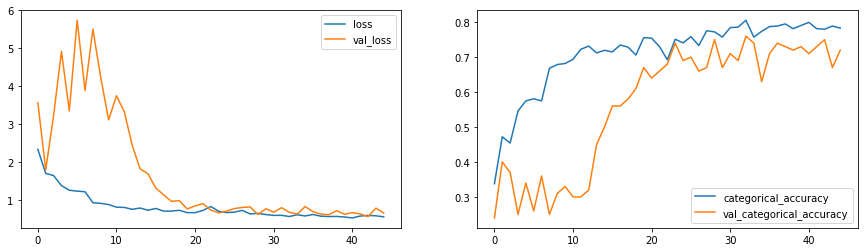

In [ ]:
plot(history)

### Experiment-11

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
#model.add(Dropout(0.05))

#Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.30))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.40))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.55))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization_35 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 5, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_22 (Conv3D)          (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_36 (Bat  (None, 5, 40, 40, 32)    128       
 chNormalization)                                                
                                                      

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.00000001, batch_size=20, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=45, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 20

totalFolders= 663 num_batches =  33 folders_remanining= 3
Epoch 1/45
32/34 [===========================>..] - ETA: 2s - loss: 2.0630 - categorical_accuracy: 0.3812
Pending - folders_remanining 3 start_from= 660 end_at= 663 batch_size= 3
33/34 [============================>.] - ETA: 1s - loss: 2.0477 - categorical_accuracy: 0.3803
totalFolders= 663 num_batches =  33 folders_remanining= 3
34/34 [==============================] - ETA: 0s - loss: 2.0394 - categorical_accuracy: 0.3831
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 20

totalFolders= 100 num_batches =  5 folders_remanining= 0

totalFolders= 100 num_batches =  5 folders_remanining= 0
34/34 [==============================] - 50s 1s/step - loss: 2.0394 - categorical_accuracy: 0.3831 - va

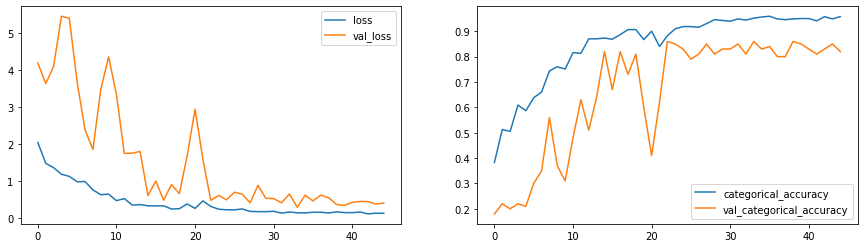

In [ ]:
plot(history)

### Experiment-12

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
#model.add(Dropout(0.05))

#Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.30))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.45))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(100, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(200, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.55))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization (BatchN  (None, 15, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 40, 40, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_1 (Batc  (None, 5, 40, 40, 32)    128       
 hNormalization)                                                 
                                                        

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.00000001, batch_size=20, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=45, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 20

totalFolders= 663 num_batches =  33 folders_remanining= 3
Epoch 1/45
32/34 [===========================>..] - ETA: 3:54 - loss: 2.0846 - categorical_accuracy: 0.3688
Pending - folders_remanining 3 start_from= 660 end_at= 663 batch_size= 3
33/34 [============================>.] - ETA: 1:57 - loss: 2.0742 - categorical_accuracy: 0.3742
totalFolders= 663 num_batches =  33 folders_remanining= 3
34/34 [==============================] - ETA: 0s - loss: 2.0888 - categorical_accuracy: 0.3741  
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 20

totalFolders= 100 num_batches =  5 folders_remanining= 0

totalFolders= 100 num_batches =  5 folders_remanining= 0
34/34 [==============================] - 4344s 131s/step - loss: 2.0888 - categorical_accuracy: 0

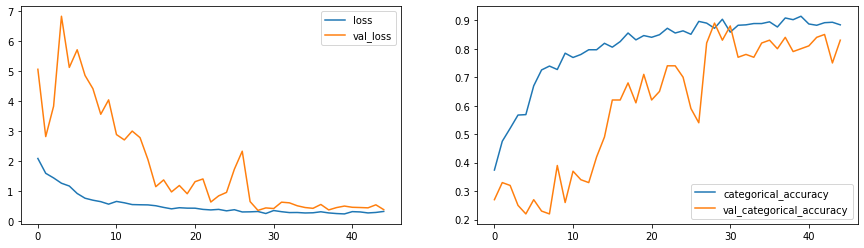

In [ ]:
plot(history)

### Experiment-13

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
#model.add(Dropout(0.05))

#Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.30))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.45))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(80, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(160, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.55))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization_5 (Batc  (None, 15, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 5, 40, 40, 16)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_6 (Batc  (None, 5, 40, 40, 32)    128       
 hNormalization)                                                 
                                                      

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.00000001, batch_size=20, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=45, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 20

totalFolders= 663 num_batches =  33 folders_remanining= 3
Epoch 1/45
32/34 [===========================>..] - ETA: 2s - loss: 2.0736 - categorical_accuracy: 0.3375
Pending - folders_remanining 3 start_from= 660 end_at= 663 batch_size= 3
33/34 [============================>.] - ETA: 1s - loss: 2.0594 - categorical_accuracy: 0.3394
totalFolders= 663 num_batches =  33 folders_remanining= 3
34/34 [==============================] - ETA: 0s - loss: 2.0541 - categorical_accuracy: 0.3409
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 20

totalFolders= 100 num_batches =  5 folders_remanining= 0

totalFolders= 100 num_batches =  5 folders_remanining= 0
34/34 [==============================] - 51s 2s/step - loss: 2.0541 - categorical_accuracy: 0.3409 - va

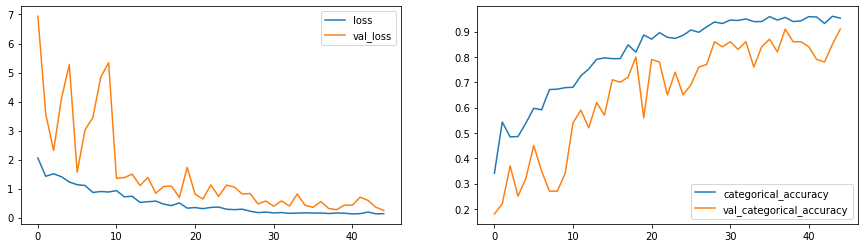

In [ ]:
plot(history)

### Experiment-14

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
#model.add(Dropout(0.05))

#Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.30))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.45))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(70, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(140, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.55))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization_10 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 5, 40, 40, 16)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_11 (Bat  (None, 5, 40, 40, 32)    128       
 chNormalization)                                                
                                                      

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.00000001, batch_size=20, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=50, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 20

totalFolders= 663 num_batches =  33 folders_remanining= 3
Epoch 1/50
32/34 [===========================>..] - ETA: 2s - loss: 2.0681 - categorical_accuracy: 0.3547
Pending - folders_remanining 3 start_from= 660 end_at= 663 batch_size= 3
33/34 [============================>.] - ETA: 1s - loss: 2.0746 - categorical_accuracy: 0.3500
totalFolders= 663 num_batches =  33 folders_remanining= 3
34/34 [==============================] - ETA: 0s - loss: 2.0827 - categorical_accuracy: 0.3484
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 20

totalFolders= 100 num_batches =  5 folders_remanining= 0

totalFolders= 100 num_batches =  5 folders_remanining= 0
34/34 [==============================] - 49s 1s/step - loss: 2.0827 - categorical_accuracy: 0.3484 - va

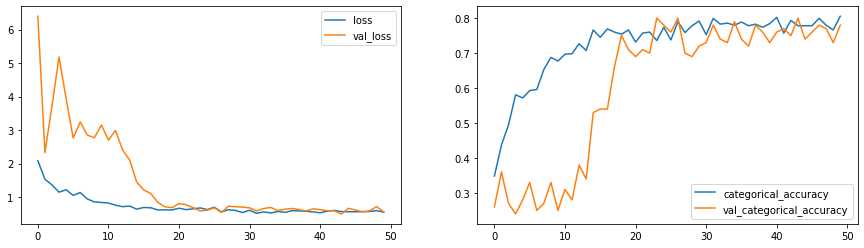

In [ ]:
plot(history)

### Experiment-15

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
#model.add(Dropout(0.05))

#Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.30))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.45))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(80, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(160, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.55))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization_15 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 5, 40, 40, 16)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_16 (Bat  (None, 5, 40, 40, 32)    128       
 chNormalization)                                                
                                                      

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.00000001, batch_size=20, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=50, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 20

totalFolders= 663 num_batches =  33 folders_remanining= 3
Epoch 1/50
32/34 [===========================>..] - ETA: 2s - loss: 2.0424 - categorical_accuracy: 0.3531
Pending - folders_remanining 3 start_from= 660 end_at= 663 batch_size= 3
33/34 [============================>.] - ETA: 1s - loss: 2.0348 - categorical_accuracy: 0.3545
totalFolders= 663 num_batches =  33 folders_remanining= 3
34/34 [==============================] - ETA: 0s - loss: 2.0315 - categorical_accuracy: 0.3560
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 20

totalFolders= 100 num_batches =  5 folders_remanining= 0

totalFolders= 100 num_batches =  5 folders_remanining= 0
34/34 [==============================] - 49s 1s/step - loss: 2.0315 - categorical_accuracy: 0.3560 - va

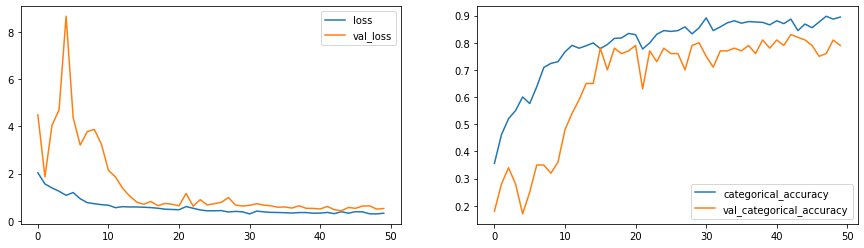

In [ ]:
plot(history)

### Experiment-16

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
#model.add(Dropout(0.05))

#Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.30))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.45))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(80, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(160, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.55))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization (BatchN  (None, 15, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 40, 40, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_1 (Batc  (None, 5, 40, 40, 32)    128       
 hNormalization)                                                 
                                                        

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.00000001, batch_size=18, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=45, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 18

totalFolders= 663 num_batches =  36 folders_remanining= 15
Epoch 1/45
35/37 [===========================>..] - ETA: 2s - loss: 2.0090 - categorical_accuracy: 0.3619
Pending - folders_remanining 15 start_from= 648 end_at= 663 batch_size= 15
36/37 [============================>.] - ETA: 1s - loss: 2.0056 - categorical_accuracy: 0.3627
totalFolders= 663 num_batches =  36 folders_remanining= 15
37/37 [==============================] - ETA: 0s - loss: 1.9972 - categorical_accuracy: 0.3635
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 18

totalFolders= 100 num_batches =  5 folders_remanining= 10

Pending - folders_remanining 10 start_from= 90 end_at= 100 batch_size= 10

totalFolders= 100 num_batches =  5 folders_remanining= 10
37/37 [===============

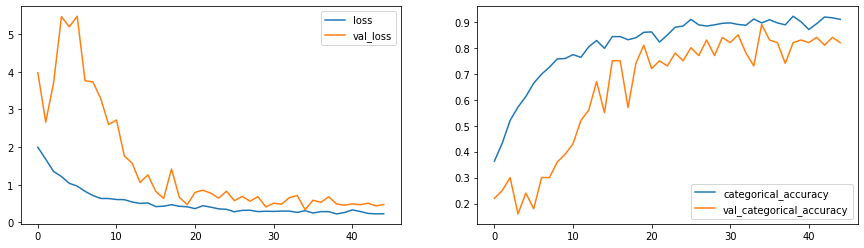

In [ ]:
plot(history)

### Experiment-17

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
#model.add(Dropout(0.05))

#Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.30))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.45))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(80, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(160, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.55))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization (BatchN  (None, 15, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 40, 40, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_1 (Batc  (None, 5, 40, 40, 32)    128       
 hNormalization)                                                 
                                                        

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.00000001, batch_size=18, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=50, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 18

totalFolders= 663 num_batches =  36 folders_remanining= 15
Epoch 1/50
35/37 [===========================>..] - ETA: 4:06 - loss: 2.1294 - categorical_accuracy: 0.3413
Pending - folders_remanining 15 start_from= 648 end_at= 663 batch_size= 15
36/37 [============================>.] - ETA: 2:03 - loss: 2.1197 - categorical_accuracy: 0.3441
totalFolders= 663 num_batches =  36 folders_remanining= 15
37/37 [==============================] - ETA: 0s - loss: 2.0962 - categorical_accuracy: 0.3499  
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 18

totalFolders= 100 num_batches =  5 folders_remanining= 10

Pending - folders_remanining 10 start_from= 90 end_at= 100 batch_size= 10

totalFolders= 100 num_batches =  5 folders_remanining= 10
37/37 [=========

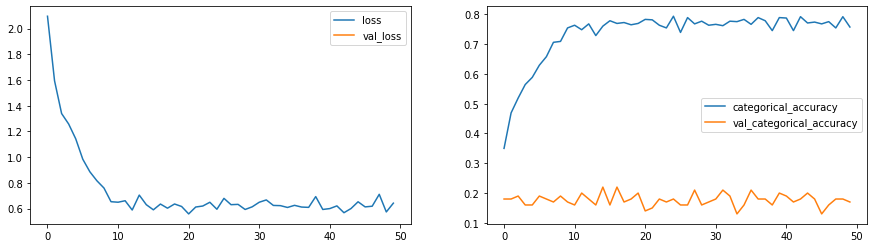

In [ ]:
plot(history)

### Experiment-18

In [ ]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
#model.add(Dropout(0.05))

#Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.30))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.45))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# Ftrst Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(80, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(160, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.55))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization_5 (Batc  (None, 15, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 5, 40, 40, 16)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_6 (Batc  (None, 5, 40, 40, 32)    128       
 hNormalization)                                                 
                                                      

In [ ]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.00000001, batch_size=18, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=27, p_preprocess_input=False, model=model,img_idx=img_idx_tmp)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 18

totalFolders= 663 num_batches =  36 folders_remanining= 15
Epoch 1/27
35/37 [===========================>..] - ETA: 2s - loss: 2.0366 - categorical_accuracy: 0.3492
Pending - folders_remanining 15 start_from= 648 end_at= 663 batch_size= 15
36/37 [============================>.] - ETA: 1s - loss: 2.0371 - categorical_accuracy: 0.3519
totalFolders= 663 num_batches =  36 folders_remanining= 15
37/37 [==============================] - ETA: 0s - loss: 2.0241 - categorical_accuracy: 0.3544
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 18

totalFolders= 100 num_batches =  5 folders_remanining= 10

Pending - folders_remanining 10 start_from= 90 end_at= 100 batch_size= 10

totalFolders= 100 num_batches =  5 folders_remanining= 10
37/37 [===============

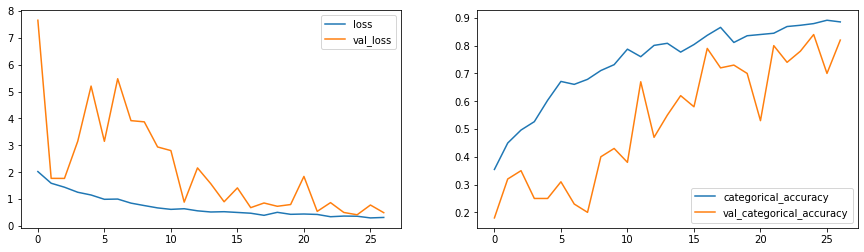

In [ ]:
plot(history)

### Experiment 19 (Best Model)

In [31]:
input_shape=(15,120,120,3)
num_classes = 5

model = Sequential()

# First Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#ELU is a function that tend to converge cost to zero faster and produce more accurate results

model.add(Conv3D(16, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(3,3,3)))
#model.add(Dropout(0.05))

#Second Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(32, kernel_size=(4,4,4), padding='same', activation='elu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.30))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.45))

# Third Convolutional layer with Batch Normalisation followed by Pooling layer and drop out
#model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

#Flatten Layers
model.add(Flatten())

# First Fully Connected Layer with Dropout and Batch Normalisation
model.add(Dense(80, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Second Fully Connected Layer with Batch Normalisation
model.add(Dense(160, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.55))

# Softmax Layer
model.add(Dense(num_classes, activation='softmax'))

optimiser = 'Adam' # optimizer 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 120, 120, 16)  3088      
                                                                 
 batch_normalization_5 (Batc  (None, 15, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 5, 40, 40, 16)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 5, 40, 40, 32)     32800     
                                                                 
 batch_normalization_6 (Batc  (None, 5, 40, 40, 32)    128       
 hNormalization)                                                 
                                                      

In [32]:
curr_dt_time = datetime.datetime.now()
img_idx_tmp = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]
history=train_model(curr_dt_time, min_lr=0.00000001, batch_size=20, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=45, p_preprocess_input=False, model=model,img_idx=img_idx_tmp,save_model=True)
print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/ ; batch size = 20

totalFolders= 663 num_batches =  33 folders_remanining= 3
Epoch 1/45
32/34 [===========================>..] - ETA: 2s - loss: 2.0728 - categorical_accuracy: 0.3344
Pending - folders_remanining 3 start_from= 660 end_at= 663 batch_size= 3
33/34 [============================>.] - ETA: 1s - loss: 2.0531 - categorical_accuracy: 0.3394
totalFolders= 663 num_batches =  33 folders_remanining= 3
34/34 [==============================] - ETA: 0s - loss: 2.0497 - categorical_accuracy: 0.3379
Source path =  /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/val/ ; batch size = 20

totalFolders= 100 num_batches =  5 folders_remanining= 0

totalFolders= 100 num_batches =  5 folders_remanining= 0

Epoch 00001: val_categorical_accuracy improved from -inf to 0.18000, saving model to /content/gdrive/M

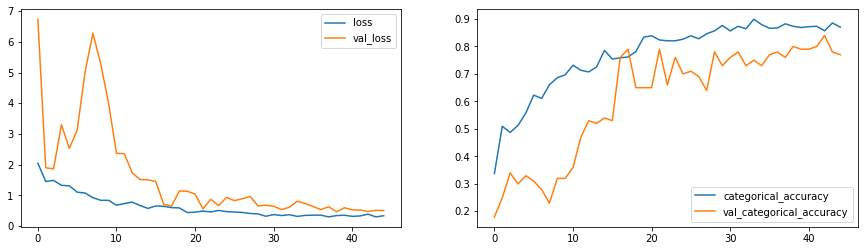

In [33]:
plot(history)